In [0]:
%matplotlib inline
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets,models,transforms
import requests

In [0]:
vgg=models.vgg19(pretrained=True).features
for param in vgg.parameters():
 param.requires_grad_(False)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:11<00:00, 48567818.44it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_imag(img_path,max_size=400,shape=None):
  if "http" in img_path:
    response=requests.get(img_path)
    image=Image.open(img_path).convert('RGB')
  else:
    image=Image.open(img_path).convert('RGB')
  if max(image.size)>max_size:
    size=max_size
  else:
    size=image.size
  if shape is not None:
    size=shape
    
  transform=transforms.Compose([transforms.Resize(size),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  #print("bfr",transform(image))
  image=transform(image)[:3,:,:].unsqueeze(0)
  #print("aftr",image)
  return image

In [0]:
content=load_imag("/content/styl7.jpg").to(device)
style=load_imag("/content/styl5.jpg").to(device)

In [0]:
def im_tensor(tensor):
  image=tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

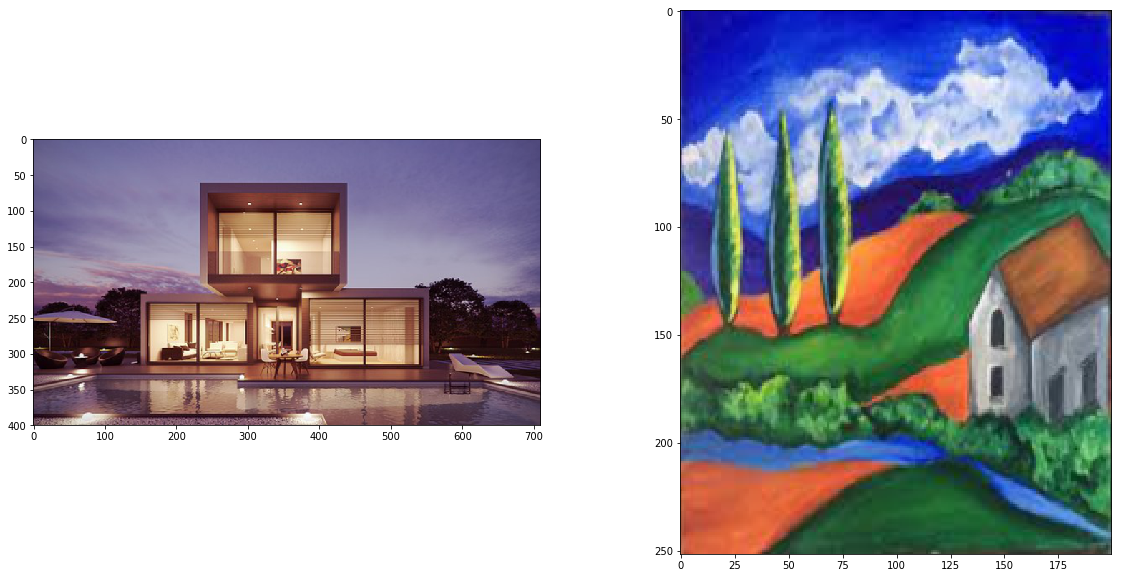

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_tensor(content))
ax2.imshow(im_tensor(style))

In [0]:
def features(img,model,layers=None):
  if layers is None:
    layers={'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
  features={}
  x=img
  for name, layer in model._modules.items():
    x=layer(x)
    if name in layers:
      #print(name)
      features[layers[name]]=x
      #print(x)
  return features

In [0]:
def gram_matrxi(tensor):
  _,d,h,w=tensor.size()
  tensor=tensor.view(d,h*w)
  #print(tensor)
  gram=torch.mm(tensor,tensor.t())
  return gram

In [0]:
content_features=features(content,vgg)
style_features=features(style,vgg)
style_grams = {layer: gram_matrxi(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)


In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e9

Total loss:  13921686528.0


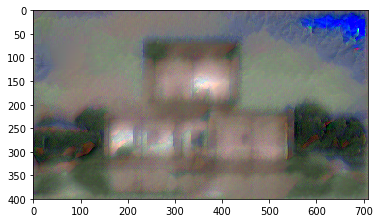

In [0]:
show_every=400
opt=optim.Adam([target],lr=0.003)
epoch=2000
for i in range(1,epoch+1):
  target_features=features(target,vgg)
  content_loss=torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss=0
  for layer in style_weights:
    target_feature=target_features[layer]
    target_gram=gram_matrxi(target_feature)
    _,d,h,w=target_feature.shape
    style_gram=style_grams[layer]
    layer_style_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    style_loss+=layer_style_loss/(d*h*w)
  total_loss = content_weight * content_loss + style_weight * style_loss
  opt.zero_grad()
  total_loss.backward()
  opt.step()
  if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_tensor(target))
        plt.show()

Total loss:  1089823.75


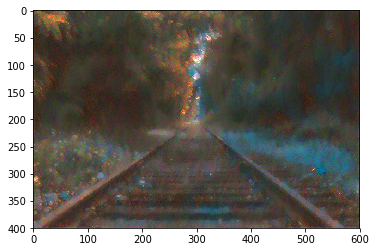

In [0]:
if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_tensor(target))
        plt.show()